In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_file_path = r"C:\tsy21001\BML Project\E-MTAB-11349\ArrayExpress-normalized.csv"
metadata_file_path = r"C:\tsy21001\BML Project\E-MTAB-11349\E-MTAB-11349.sdrf.txt"

def process_gene_expression_data(file_path, metadata_path):
    matrix = pd.read_csv(file_path)
    
    matrix = matrix.set_index('gene')
    matrix = matrix.T
    
    processed_data = pd.DataFrame(matrix)
    
    features_df = pd.read_csv(metadata_path, sep='\t', index_col=0)
    
    return processed_data, features_df

train_data, train_features = process_gene_expression_data(train_file_path, metadata_file_path)


In [3]:
train_data = train_data.drop(train_data.index[:2])
train_data

gene,ACADS,ACADVL,ACAT1,PSEN1,ADA,ADRB2,ADRB3,ADSL,AGA,ALAD,...,ALOX12-AS1,CYP21A1P,LOC100506990,LOC100506123,LINC01721,PCAT19,ANKRD20A5P,LINC00547,LINC00941,LINC00700
Sample 1,71.394731,202.285072,51.923441,1502.534571,155.770323,236.900699,4.326953,283.415448,122.236434,257.453728,...,493.2727,18.38955,100.6017,188.2225,3.245215,33.53389,23.79824,0.0,175.2416,55.16866
Sample 2,104.829005,308.215194,71.677952,1245.404416,215.033856,267.000371,6.271821,268.79232,120.956544,275.960115,...,422.8999,42.1108,68.09405,225.7855,8.959744,27.77521,13.43962,1.791949,116.4767,42.1108
Sample 3,173.466488,271.920441,80.87289,930.624269,257.855591,470.000418,16.408992,350.449189,134.78815,364.51404,...,307.0826,4.688283,104.3143,294.1898,5.860354,21.09728,39.85041,2.344142,80.87289,26.95763
Sample 4,103.796604,232.756022,80.992805,754.098056,247.696442,394.741631,6.290703,419.118106,61.334357,319.253192,...,392.3826,3.93169,69.19774,379.8012,7.077041,38.53056,18.87211,0.786338,99.07858,40.10323
Sample 5,83.472519,219.115362,57.861632,1089.885502,145.128357,181.173308,11.382616,315.8676,113.826162,239.983492,...,352.8611,128.0544,115.7233,518.8576,48.37612,129.9515,29.40509,36.9935,350.0154,207.7327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample 586,147.529335,278.935246,71.74924,1035.123862,216.860061,388.574534,11.286397,366.80791,112.863972,274.098219,...,336.1734,12.89874,80.61712,232.9835,4.837027,24.99131,24.99131,4.030856,91.09735,42.72708
Sample 587,94.187393,306.109028,53.515564,1343.240664,172.320117,187.304475,6.421868,278.280934,126.296732,323.234008,...,325.3746,5.351556,96.32802,180.8826,3.210934,34.24996,11.77342,8.56249,107.0311,62.07805
Sample 588,87.027568,230.201954,45.853235,2358.166354,111.357856,363.082756,10.293583,320.036862,79.541325,230.201954,...,417.358,10.29358,78.60555,126.3303,6.550462,33.68809,4.678901,2.807341,174.9909,46.78901
Sample 589,84.236132,170.323607,99.972552,2184.58539,135.148079,186.985699,1.851344,354.53229,147.181812,268.444815,...,412.8496,10.18239,119.4117,137.9251,5.554031,36.1012,42.5809,1.851344,102.7496,43.50657


In [5]:
columns_to_keep = ['Characteristics[age]', 'Characteristics[sex]', 'Characteristics[disease]']
filtered_train_features = train_features[columns_to_keep]
filtered_train_features = filtered_train_features.rename(columns={
    'Characteristics[age]': 'Age',
    'Characteristics[sex]': 'Sex',
    'Characteristics[disease]': 'Disease'
})

disease_mapping = {
    'normal': 0,
    "Crohn's disease": 1,
    'ulcerative colitis': 2
}

filtered_train_features['Disease_Label'] = filtered_train_features['Disease'].map(disease_mapping)

filtered_train_features

,Age,Sex,Disease,Disease_Label
Source Name,,,,
Sample 1,34,male,Crohn's disease,1
Sample 2,49,female,normal,0
Sample 3,27,male,normal,0
Sample 4,9,male,normal,0
Sample 5,34,female,normal,0
...,...,...,...,...
Sample 586,25,male,Crohn's disease,1
Sample 587,44,male,normal,0
Sample 588,36,female,Crohn's disease,1


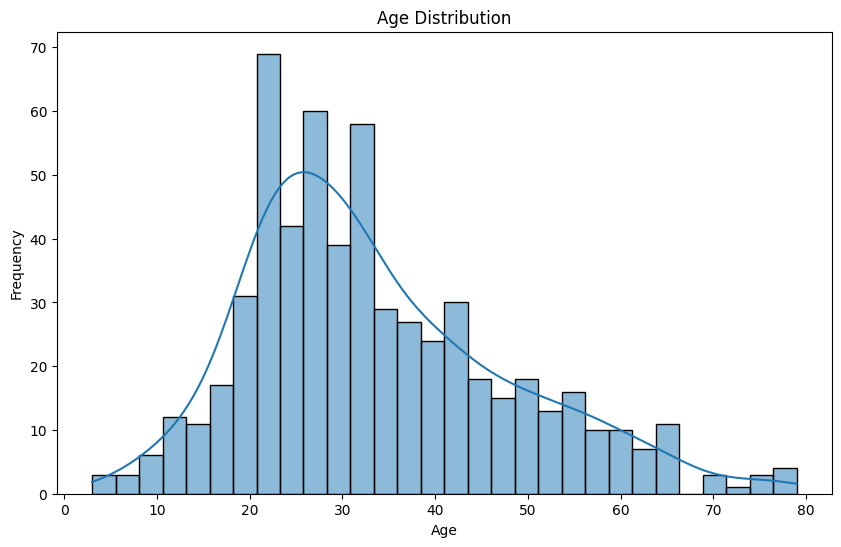

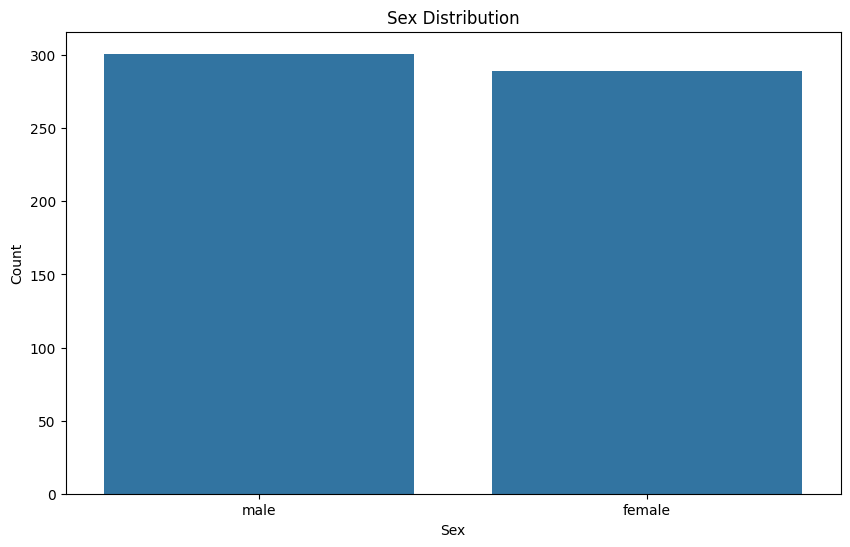

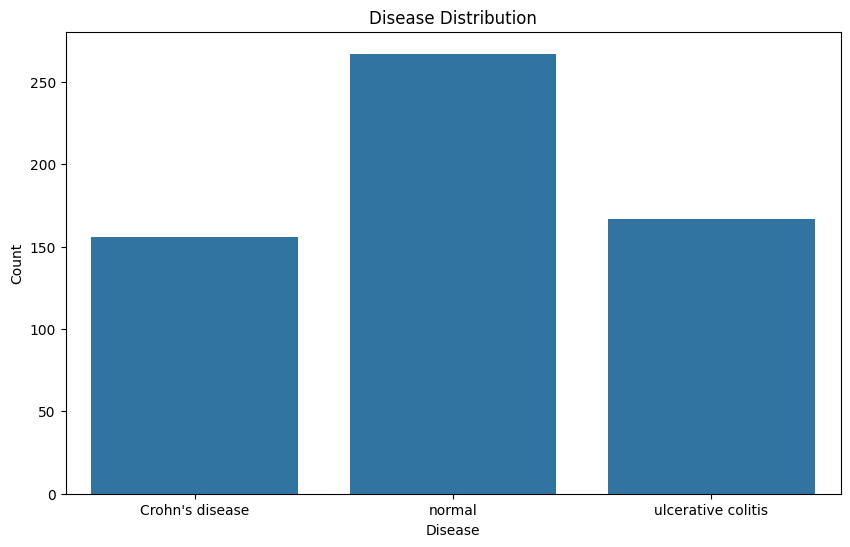

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_train_features['Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', data=filtered_train_features)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Disease', data=filtered_train_features)
plt.title('Disease Distribution')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.show()